# **1.1.** Prepare data set

In [ ]:
%%capture 
!pip install fashionpedia
!pip install split-folders
!$ yes | python -m pip uninstall matplotlib
!$ yes | pip install matplotlib==3.1.3
#!pip install albumentations==0.3.0



> **Importing Modules**



In [ ]:
import os
import shutil
import random
import itertools
import splitfolders
import functools
import cv2
import json
import numpy as np
import pandas as pd
import torch
from skimage.io import imread
from skimage.transform import resize
from skimage.measure import find_contours, regionprops, label
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.python.keras.utils import data_utils
import h5py
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from fashionpedia.fp import Fashionpedia
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
import colorsys
import matplotlib.pyplot as plt
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
import IPython.display

In [ ]:
!wget https://s3.amazonaws.com/ifashionist-dataset/annotations/instances_attributes_train2020.json

--2021-08-19 21:17:52--  https://s3.amazonaws.com/ifashionist-dataset/annotations/instances_attributes_train2020.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.141.142
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.141.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 542193045 (517M) [application/json]
Saving to: ‘instances_attributes_train2020.json’

instances_attribute 100%[===================>] 517.08M  35.7MB/s    in 15s     

2021-08-19 21:18:08 (33.8 MB/s) - ‘instances_attributes_train2020.json’ saved [542193045/542193045]



In [ ]:
!wget https://s3.amazonaws.com/ifashionist-dataset/images/train2020.zip

--2021-08-19 21:18:08--  https://s3.amazonaws.com/ifashionist-dataset/images/train2020.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.92.54
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.92.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3344364592 (3.1G) [application/zip]
Saving to: ‘train2020.zip’

train2020.zip       100%[===================>]   3.11G  36.2MB/s    in 95s     

2021-08-19 21:19:44 (33.4 MB/s) - ‘train2020.zip’ saved [3344364592/3344364592]



In [ ]:
%%capture 
#Simply adding &> /dev/null to the tail of any command will silence its output outside of any errors that may arise.
!unzip /content/train2020.zip && rm /content/train2020.zip

In [ ]:
#!wget https://s3.amazonaws.com/ifashionist-dataset/annotations/instances_attributes_val2020.json

In [ ]:
#!wget https://s3.amazonaws.com/ifashionist-dataset/images/val_test2020.zip

In [ ]:
#!unzip /content/val_test2020.zip


**Dataset Taxonomy**
```
+---------+-----------------------------------------+----------------+
| ClassId |                   Name                  | SuperCategory  |
+---------+-----------------------------------------+----------------+
|    0    |              shirt, blouse              |   upperbody    |
|    1    |         top, t-shirt, sweatshirt        |   upperbody    |
|    2    |                 sweater                 |   upperbody    |
|    3    |                 cardigan                |   upperbody    |
|    4    |                  jacket                 |   upperbody    |
|    5    |                   vest                  |   upperbody    |
|    6    |                  pants                  |   lowerbody    |
|    7    |                  shorts                 |   lowerbody    |
|    8    |                  skirt                  |   lowerbody    |
|    9    |                   coat                  |   wholebody    |
|    10   |                  dress                  |   wholebody    |
|    11   |                 jumpsuit                |   wholebody    |
|    12   |                   cape                  |   wholebody    |
|    13   |                 glasses                 |      head      |
|    14   |                   hat                   |      head      |
|    15   | headband, head covering, hair accessory |      head      |
|    16   |                   tie                   |      neck      |
|    17   |                  glove                  | arms and hands |
|    18   |                  watch                  | arms and hands |
|    19   |                   belt                  |     waist      |
|    20   |                leg warmer               | legs and feet  |
|    21   |            tights, stockings            | legs and feet  |
|    22   |                   sock                  | legs and feet  |
|    23   |                   shoe                  | legs and feet  |
|    24   |               bag, wallet               |     others     |
|    25   |                  scarf                  |     others     |
|    26   |                 umbrella                |     others     |
|    27   |                   hood                  | garment parts  |
|    28   |                  collar                 | garment parts  |
|    29   |                  lapel                  | garment parts  |
|    30   |                epaulette                | garment parts  |
|    31   |                  sleeve                 | garment parts  |
|    32   |                  pocket                 | garment parts  |
|    33   |                 neckline                | garment parts  |
|    34   |                  buckle                 |    closures    |
|    35   |                  zipper                 |    closures    |
|    36   |                 applique                |  decorations   |
|    37   |                   bead                  |  decorations   |
|    38   |                   bow                   |  decorations   |
|    39   |                  flower                 |  decorations   |
|    40   |                  fringe                 |  decorations   |
|    41   |                  ribbon                 |  decorations   |
|    42   |                  rivet                  |  decorations   |
|    43   |                  ruffle                 |  decorations   |
|    44   |                  sequin                 |  decorations   |
|    45   |                  tassel                 |  decorations   |
+---------+-----------------------------------------+----------------+
```
[Data Link](https://www.kaggle.com/c/imaterialist-fashion-2020-fgvc7/overview/evaluation)


In [ ]:
def get_masks(root_dir, ann_dir):
    """
    Get the masks from annotated json file data.
    Parameters
    ----------
    root_dir : string
        File path to save masks.
    ann_dir : string
        Annotations path folder.
    Return
    ----------
    img_ids : ndarray
        Used image index numbers.
    Atts
    ---------- 
    labels = [[0, 1, 2, 3, 4, 5, 28, 29, 30, 33], 
            [6, 7, 8], 
            [9, 10, 11, 12], 
            [20, 21, 22, 23],
            [13, 14, 15, 16, 17, 18, 19, 24, 25, 26, 34, 37, 38]]
    
        1 'upperbody' -> 0, 1, 2, 3, 4, 5, 27, 28, 29, 30, 31, 33, 9, 10, 11, 12
        2 'lowerbody' -> 6, 7, 8, 21, 32
        3 'feet' -> 20, 22, 23
        4 'accessories' -> 13, 14, 15, 16, 17, 18, 19, 24, 25, 26, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45

        34 ve 35 fermuar ve kemer tokası
    """
    mask_root=os.path.join(root_dir, 'masks')
    images_root=os.path.join(root_dir, 'images')
    if not os.path.exists(mask_root):
        os.makedirs(mask_root)
    if not os.path.exists(images_root):
        os.makedirs(images_root)

    fp = Fashionpedia(ann_dir)
    img_ids = sorted(fp.getImgIds())
    annotations = fp.loadAnns(ids=img_ids)
    cat_ids = fp.getCatIds()
    labels = [[0, 1, 2, 3, 4, 5], #upperbody
            [6, 7, 8], #lowerbody
            [9, 10, 11], #wholebody
            [20, 22, 23], #feet
            [13, 14, 15, 16, 17, 18, 19, 24, 25, 26, 34, 37]] #accessories
    
    images=[]
    img_ids=[]
    for ann in annotations:
        img_ids.append(ann['image_id'])

    img_ids = np.asarray(img_ids)
    img_ids = np.unique(img_ids)

    for img_id in img_ids:
        anns_ids = fp.getAnnIds(imgIds=img_id, catIds=cat_ids)
        anns = fp.loadAnns(anns_ids)
        mask = np.zeros_like(fp.annToMask(anns[0]))
        img = fp.loadImgs(anns[0]['image_id'])[0]
        images.append(os.path.join('/content/train', img['file_name']))
        path = os.path.join(mask_root, img['file_name'])
        path = path.split('.')[0] + '_mask.png'
        for ann in anns:
            if ann['category_id'] in labels[0]:#upperbody
                label = 1
            elif ann['category_id'] in labels[1]:#lowerboy
                label = 2
            elif ann['category_id'] in labels[2]:#wholebody
                label = 3
            elif ann['category_id'] in labels[3]:#feet
                label = 4
            elif ann['category_id'] in labels[4]:#accessories
                label = 5
            else:
                label = 0
            mask = np.maximum(mask, fp.annToMask(ann)*label) # mask += fp.annToMask(ann)*label
        cv2.imwrite(path, mask)
    
    for f in images:
        shutil.move(f, images_root)

    return img_ids

In [ ]:
img_ids = get_masks(root_dir='/content/data/', ann_dir='/content/instances_attributes_train2020.json')

loading annotations into memory...
Done (t=24.69s)
creating index...
index created!
loading attributes...
attributes index created!


In [ ]:
shutil.rmtree("/content/train")
input_folder = '/content/data/'

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output="datas", seed=1337, ratio=(.8, .1, .1), group_prefix=None) # default values
shutil.rmtree("/content/data")

Copying files: 13520 files [00:05, 2673.55 files/s]


In [ ]:
#img_ids = get_masks(root_dir='/content/val_masks', ann_dir='/content/instances_attributes_val2020.json')

In [ ]:
#%%capture 
#!zip -r mask_train.zip /content/masks

#**1.2.** DeepLabV3+

[Link](https://arxiv.org/pdf/1802.02611.pdf)

<div>
<img src="https://paperswithcode.com/media/models/Screen_Shot_2021-02-21_at_10.34.37_AM_kvOFts0.png" width="690"/>
</div>

### **DataGenerator**

In [ ]:
class DataGenerator(data_utils.Sequence): 
    """
    Generates data for Keras Sequence based data generator. 
    Suitable for building data generator for training and prediction.
    This class for a multiclass segmentation and superclass from
    tensorflow.keras.utils.Sequence
    Parameters
    ----------
    data_dir : string
        The parent name of the directory where the data is located.
        (Path to images and masks location.)
    to_fit : boolean, default=True
        Create a data generator based on this parameter 
        for training or prediction. True to return X and y, 
        False to return X only.
    batch_size : int, default=32
        Batch size at each iteration.
    dim : tuple or list, default=(256, 256)
        Tuple indicating for image dimension.
    n_channels : int, default=3
        Number of image channels.
    n_classes : int, default=1
        Number of classes.
    shuffle : boolean, default=True
        True to shuffle label indexes after every epoch.
    seed : int, seed instance or None, default=None
        Determines random number generation for shuffle label indexes. 
        Use an int to make the randomness deterministic.
    preprocessing_function : default=None 
        Data preprocessing (e.g. normalization, shape manipulation, etc.). 
        function that will be applied on each input.
        The function will run after the image is resized and augmented.
        The function should take one argument:
        Argument:
            image : ndarray
                input image for preprocessing. (*dim, 3)
    interpolation : string, default='nearest'
         Interpolation method used to resample the image if the target 
         size is different from that of the loaded image. 
         Supported methods are "nearest", "bilinear", and "bicubic". 
         If PIL version 1.1.3 or newer is installed, "lanczos" is also supported. 
         If PIL version 3.4.0 or newer is installed, "box" and "hamming" 
         are also supported. By default, "nearest" is used.
    """
    def __init__(self, data_dir, to_fit=True, batch_size=32, 
                 dim=(256, 256), dtype=np.uint8, n_channels=3, 
                 n_classes=1, shuffle=True, seed=None, 
                 preprocessing_function=None, interpolation='nearest'):
        self.data_dir = data_dir
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        self.dtype = dtype
        self.n_channels = n_channels
        self.interpolation = interpolation
        self.n_classes = n_classes
        self.preprocessing_function=preprocessing_function
        self.seed = seed
        self.shuffle = shuffle
        self._n_batch = 0
        self._initialize_dirs(self.data_dir)
        self.on_epoch_end()

    def __len__(self):
        """
        Denotes the number of batches per epoch.
        Returns
        -------    
        num_batches : int    
            Number of batches per epoch.
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """
        Generate one batch of data.
        Parameters
        ----------
        index : int 
            Index of the batch.
        Returns
        ----------
        X : list of ndarray shape (batch_size, *dim, n_channels)
            Number of channels image up to batch size.
        y : list of ndarray shape (batch_size, *dim, n_classes)  
            Number of classes image up to batch size.
        X and y when fitting. X only when predicting.
        """
        if self._n_batch >= self.__len__():
            self.on_epoch_end
            self._n_batch = 0

        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        list_IDs_temp = [self.list_IDs[idx] for idx in indexes]

        X = self._generate_X(list_IDs_temp)
        self._n_batch += 1
        if self.to_fit:
            y = self._generate_y(list_IDs_temp)
            return X, y
        return X            

    def on_epoch_end(self):
        """
        Updates indexes after each epoch.
        Attributes
        ----------
        indexes : list of ndarray shape (len(filenames[1]),)
            It keeps the indices as high as the size of the masks.
            If shuffle is True, shuffle the data indices and updates
            after each epoch.
        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            if self.seed is not None:
                np.random.seed(seed)
            np.random.shuffle(self.indexes)

    def __iter__(self):
        """
        Create a generator that iterate over the DataGenerator.
        """
        while True:
            for item in (self[i] for i in range(len(self))):
                yield item

    def __next__(self):
        """
        Function returns the next batches in a DataGenerator.
        """
        batches = self.__getitem__(self._n_batch)
        return batches
    
    def _initialize_dirs(self, directory):
        """
        Initialize the all data directories.
        The directory structure should be as follows.:
            data:
                test:
                    images:
                    masks:
                train:
                    images:
                    masks:
                val:
                    images:
                    masks:
        Attributes
        ----------
        filenames : list, size (2,)
            A list that keeps the full directories of images and masks.
            Index 0 is images. Index 1 is masks.
        list_IDs : list of ndarray shape (len(filenames[1]),)
            It keeps the indices as high as the size of the masks.
        """
        classes = []
        for subdir in sorted(os.listdir(directory)):
            if os.path.isdir(os.path.join(directory, subdir)):
                classes.append(subdir)

        filenames = []
        for dirpath in (os.path.join(directory, subdir) for subdir in classes):
            for roots,dirs,files in os.walk(dirpath):               
                if files:
                    sub_dirs = sorted([roots + os.sep + file for file in  files])
                    filenames.append(sub_dirs)
        
        self.filenames = filenames
        self.list_IDs = np.arange(len(filenames[0]))
        
    def _generate_X(self, list_IDs_temp):
        """
        Generates data containing batch_size images.        
        Parameters
        ----------
        list_IDs_temp : list
            List of masks ids to load.
        Returns
        ----------
        X : list of ndarray shape (batch_size, *dim, n_channels)
            Batch of images.
        """
        X = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=self.dtype)

        for i, ID in enumerate(list_IDs_temp):
            X[i,] = self._load_rgb_image(self.filenames[0][ID])
        return X

    def _generate_y(self, list_IDs_temp):
        """
        Generates data containing batch_size masks.
        Parameters
        ----------
        list_IDs_temp : list
            List of masks ids to load.
        Returns
        ----------
        y : list of ndarray shape (batch_size, *dim, n_classes)
            Batch of masks.
        """
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=self.dtype)

        for i, ID in enumerate(list_IDs_temp):
            mask = self._load_grayscale_image(self.filenames[1][ID])
            if self.n_classes is not 1:
                mask = to_categorical(mask, num_classes=self.n_classes, dtype=self.dtype)
            y[i,] = mask
        return y

    def _load_rgb_image(self, image_path):
        """
        Load RGB image from given directory.
        Supported image file formats:
        ('png', 'jpg', 'jpeg', 'bmp', 'ppm', 'tif', 'tiff')
        Parameters
        ----------
        image_path : string
            Path to image to load.
        Returns
        ----------
        img : ndarray, shape of (*dim, n_channels)
            Loaded image.
        """
        img = load_img(image_path, 
                       target_size=self.dim, 
                       interpolation=self.interpolation)
        img = img_to_array(img, dtype=self.dtype)
        if self.preprocessing_function is not None:
            img = self.preprocessing_function(img)
        return img

    def _load_grayscale_image(self, image_path):
        """
        Load grayscale image from given directory.
        Supported image file formats:
        ('png', 'jpg', 'jpeg', 'bmp', 'ppm', 'tif', 'tiff')
        Parameters
        ----------
        image_path : string
            Path to image to load.
        Returns
        ----------
        img : ndarray, shape of (*dim, 1)
            Loaded image.
        """
        img = load_img(image_path, 
                       color_mode='grayscale', 
                       target_size=self.dim, 
                       interpolation=self.interpolation)
        img = img_to_array(img, dtype=self.dtype)
        return img



> **Preprocessing Function**



In [ ]:
scaler = MinMaxScaler()
def preprocessing(img=None):
    if img is not None:
        img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
        return img



> **Initialize the Parameters**



In [ ]:
train_directory = '/content/datas/train'
val_directory = '/content/datas/val'
test_directory = '/content/datas/test'
backbone = 'inceptionresnetv2'
classes = ['background', 'upperbody', 'lowerbody', 'wholebody', 'feet', 'accessories']
n_classes = len(classes)
activation = 'sigmoid' if n_classes == 1 else 'softmax'
num_epoch = 35
LR = 1e-3
batch_size = 8
IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS = 256, 256, 3
seed = None 

params = {'to_fit':True,
          'batch_size': batch_size,
          'dim': (IMG_WIDTH,IMG_HEIGHT),
          'dtype':'float32',
          'n_channels': IMG_CHANNELS,
          'n_classes': n_classes,
          'shuffle': True,
          'seed':seed,
          'interpolation':'nearest',
          'preprocessing_function': preprocessing}

train_gen = DataGenerator(train_directory, **params)
val_gen = DataGenerator(val_directory, **params)
test_gen = DataGenerator(test_directory, **params)

### **Model**

[Source](https://github.com/bonlime/keras-deeplab-v3-plus)

In [ ]:
""" Deeplabv3+ model for Keras.
This model is based on TF repo:
https://github.com/tensorflow/models/tree/master/research/deeplab
On Pascal VOC, original model gets to 84.56% mIOU
MobileNetv2 backbone is based on this repo:
https://github.com/JonathanCMitchell/mobilenet_v2_keras
# Reference
- [Encoder-Decoder with Atrous Separable Convolution
    for Semantic Image Segmentation](https://arxiv.org/pdf/1802.02611.pdf)
- [Xception: Deep Learning with Depthwise Separable Convolutions]
    (https://arxiv.org/abs/1610.02357)
- [Inverted Residuals and Linear Bottlenecks: Mobile Networks for
    Classification, Detection and Segmentation](https://arxiv.org/abs/1801.04381)
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

from tensorflow.python.keras.models import Model
from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Reshape
from tensorflow.python.keras.layers import Activation
from tensorflow.python.keras.layers import Concatenate
from tensorflow.python.keras.layers import Add
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Conv2D
from tensorflow.python.keras.layers import DepthwiseConv2D
from tensorflow.python.keras.layers import ZeroPadding2D
from tensorflow.python.keras.layers import GlobalAveragePooling2D
from tensorflow.python.keras.utils.layer_utils import get_source_inputs
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.applications.imagenet_utils import preprocess_input

WEIGHTS_PATH_X = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_MOBILE = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_X_CS = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.2/deeplabv3_xception_tf_dim_ordering_tf_kernels_cityscapes.h5"
WEIGHTS_PATH_MOBILE_CS = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.2/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels_cityscapes.h5"


def SepConv_BN(x, filters, prefix, stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3):
    """ SepConv with BN between depthwise & pointwise. Optionally add activation after BN
        Implements right "same" padding for even kernel sizes
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & poinwise convs
            epsilon: epsilon to use in BN layer
    """

    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'

    if not depth_activation:
        x = Activation(tf.nn.relu)(x)
    x = DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),
                        padding=depth_padding, use_bias=False, name=prefix + '_depthwise')(x)
    x = BatchNormalization(name=prefix + '_depthwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation(tf.nn.relu)(x)
    x = Conv2D(filters, (1, 1), padding='same',
               use_bias=False, name=prefix + '_pointwise')(x)
    x = BatchNormalization(name=prefix + '_pointwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation(tf.nn.relu)(x)

    return x


def _conv2d_same(x, filters, prefix, stride=1, kernel_size=3, rate=1):
    """Implements right 'same' padding for even kernel sizes
        Without this there is a 1 pixel drift when stride = 2
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
    """
    if stride == 1:
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='same', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='valid', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)


def _xception_block(inputs, depth_list, prefix, skip_connection_type, stride,
                    rate=1, depth_activation=False, return_skip=False):
    """ Basic building block of modified Xception network
        Args:
            inputs: input tensor
            depth_list: number of filters in each SepConv layer. len(depth_list) == 3
            prefix: prefix before name
            skip_connection_type: one of {'conv','sum','none'}
            stride: stride at last depthwise conv
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & pointwise convs
            return_skip: flag to return additional tensor after 2 SepConvs for decoder
            """
    residual = inputs
    for i in range(3):
        residual = SepConv_BN(residual,
                              depth_list[i],
                              prefix + '_separable_conv{}'.format(i + 1),
                              stride=stride if i == 2 else 1,
                              rate=rate,
                              depth_activation=depth_activation)
        if i == 1:
            skip = residual
    if skip_connection_type == 'conv':
        shortcut = _conv2d_same(inputs, depth_list[-1], prefix + '_shortcut',
                                kernel_size=1,
                                stride=stride)
        shortcut = BatchNormalization(name=prefix + '_shortcut_BN')(shortcut)
        outputs = layers.add([residual, shortcut])
    elif skip_connection_type == 'sum':
        outputs = layers.add([residual, inputs])
    elif skip_connection_type == 'none':
        outputs = residual
    if return_skip:
        return outputs, skip
    else:
        return outputs


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id, skip_connection, rate=1):
    in_channels = inputs.shape[-1]  # inputs._keras_shape[-1]
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'expanded_conv_{}_'.format(block_id)
    if block_id:
        # Expand

        x = Conv2D(expansion * in_channels, kernel_size=1, padding='same',
                   use_bias=False, activation=None,
                   name=prefix + 'expand')(x)
        x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                               name=prefix + 'expand_BN')(x)
        x = Activation(tf.nn.relu6, name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'
    # Depthwise
    x = DepthwiseConv2D(kernel_size=3, strides=stride, activation=None,
                        use_bias=False, padding='same', dilation_rate=(rate, rate),
                        name=prefix + 'depthwise')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'depthwise_BN')(x)

    x = Activation(tf.nn.relu6, name=prefix + 'depthwise_relu')(x)

    # Project
    x = Conv2D(pointwise_filters,
               kernel_size=1, padding='same', use_bias=False, activation=None,
               name=prefix + 'project')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'project_BN')(x)

    if skip_connection:
        return Add(name=prefix + 'add')([inputs, x])

    # if in_channels == pointwise_filters and stride == 1:
    #    return Add(name='res_connect_' + str(block_id))([inputs, x])

    return x


def Deeplabv3(weights='pascal_voc', input_tensor=None, input_shape=(512, 512, 3), classes=21, backbone='mobilenetv2',
              OS=16, alpha=1., activation=None):
    """ Instantiates the Deeplabv3+ architecture
    Optionally loads weights pre-trained
    on PASCAL VOC or Cityscapes. This model is available for TensorFlow only.
    # Arguments
        weights: one of 'pascal_voc' (pre-trained on pascal voc),
            'cityscapes' (pre-trained on cityscape) or None (random initialization)
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: shape of input image. format HxWxC
            PASCAL VOC model was trained on (512,512,3) images. None is allowed as shape/width
        classes: number of desired classes. PASCAL VOC has 21 classes, Cityscapes has 19 classes.
            If number of classes not aligned with the weights used, last layer is initialized randomly
        backbone: backbone to use. one of {'xception','mobilenetv2'}
        activation: optional activation to add to the top of the network.
            One of 'softmax', 'sigmoid' or None
        OS: determines input_shape/feature_extractor_output ratio. One of {8,16}.
            Used only for xception backbone.
        alpha: controls the width of the MobileNetV2 network. This is known as the
            width multiplier in the MobileNetV2 paper.
                - If `alpha` < 1.0, proportionally decreases the number
                    of filters in each layer.
                - If `alpha` > 1.0, proportionally increases the number
                    of filters in each layer.
                - If `alpha` = 1, default number of filters from the paper
                    are used at each layer.
            Used only for mobilenetv2 backbone. Pretrained is only available for alpha=1.
    # Returns
        A Keras model instance.
    # Raises
        RuntimeError: If attempting to run this model with a
            backend that does not support separable convolutions.
        ValueError: in case of invalid argument for `weights` or `backbone`
    """

    if not (weights in {'pascal_voc', 'cityscapes', None}):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `pascal_voc`, or `cityscapes` '
                         '(pre-trained on PASCAL VOC)')

    if not (backbone in {'xception', 'mobilenetv2'}):
        raise ValueError('The `backbone` argument should be either '
                         '`xception`  or `mobilenetv2` ')

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        img_input = input_tensor

    if backbone == 'xception':
        if OS == 8:
            entry_block3_stride = 1
            middle_block_rate = 2  # ! Not mentioned in paper, but required
            exit_block_rates = (2, 4)
            atrous_rates = (12, 24, 36)
        else:
            entry_block3_stride = 2
            middle_block_rate = 1
            exit_block_rates = (1, 2)
            atrous_rates = (6, 12, 18)

        x = Conv2D(32, (3, 3), strides=(2, 2),
                   name='entry_flow_conv1_1', use_bias=False, padding='same')(img_input)
        x = BatchNormalization(name='entry_flow_conv1_1_BN')(x)
        x = Activation(tf.nn.relu)(x)

        x = _conv2d_same(x, 64, 'entry_flow_conv1_2', kernel_size=3, stride=1)
        x = BatchNormalization(name='entry_flow_conv1_2_BN')(x)
        x = Activation(tf.nn.relu)(x)

        x = _xception_block(x, [128, 128, 128], 'entry_flow_block1',
                            skip_connection_type='conv', stride=2,
                            depth_activation=False)
        x, skip1 = _xception_block(x, [256, 256, 256], 'entry_flow_block2',
                                   skip_connection_type='conv', stride=2,
                                   depth_activation=False, return_skip=True)

        x = _xception_block(x, [728, 728, 728], 'entry_flow_block3',
                            skip_connection_type='conv', stride=entry_block3_stride,
                            depth_activation=False)
        for i in range(16):
            x = _xception_block(x, [728, 728, 728], 'middle_flow_unit_{}'.format(i + 1),
                                skip_connection_type='sum', stride=1, rate=middle_block_rate,
                                depth_activation=False)

        x = _xception_block(x, [728, 1024, 1024], 'exit_flow_block1',
                            skip_connection_type='conv', stride=1, rate=exit_block_rates[0],
                            depth_activation=False)
        x = _xception_block(x, [1536, 1536, 2048], 'exit_flow_block2',
                            skip_connection_type='none', stride=1, rate=exit_block_rates[1],
                            depth_activation=True)

    else:
        OS = 8
        first_block_filters = _make_divisible(32 * alpha, 8)
        x = Conv2D(first_block_filters,
                   kernel_size=3,
                   strides=(2, 2), padding='same', use_bias=False,
                   name='Conv' if input_shape[2] == 3 else 'Conv_')(img_input)
        x = BatchNormalization(
            epsilon=1e-3, momentum=0.999, name='Conv_BN')(x)
        x = Activation(tf.nn.relu6, name='Conv_Relu6')(x)

        x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1,
                                expansion=1, block_id=0, skip_connection=False)

        x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2,
                                expansion=6, block_id=1, skip_connection=False)
        x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1,
                                expansion=6, block_id=2, skip_connection=True)

        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2,
                                expansion=6, block_id=3, skip_connection=False)
        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                                expansion=6, block_id=4, skip_connection=True)
        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                                expansion=6, block_id=5, skip_connection=True)

        # stride in block 6 changed from 2 -> 1, so we need to use rate = 2
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,  # 1!
                                expansion=6, block_id=6, skip_connection=False)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=7, skip_connection=True)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=8, skip_connection=True)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=9, skip_connection=True)

        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=10, skip_connection=False)
        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=11, skip_connection=True)
        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=12, skip_connection=True)

        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=2,  # 1!
                                expansion=6, block_id=13, skip_connection=False)
        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=14, skip_connection=True)
        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=15, skip_connection=True)

        x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=16, skip_connection=False)

    # end of feature extractor

    # branching for Atrous Spatial Pyramid Pooling

    # Image Feature branch
    shape_before = tf.shape(x)
    b4 = GlobalAveragePooling2D()(x)
    b4_shape = tf.keras.backend.int_shape(b4)
    # from (b_size, channels)->(b_size, 1, 1, channels)
    b4 = Reshape((1, 1, b4_shape[1]))(b4)
    b4 = Conv2D(256, (1, 1), padding='same',
                use_bias=False, name='image_pooling')(b4)
    b4 = BatchNormalization(name='image_pooling_BN', epsilon=1e-5)(b4)
    b4 = Activation(tf.nn.relu)(b4)
    # upsample. have to use compat because of the option align_corners
    size_before = tf.keras.backend.int_shape(x)
    b4 = tf.keras.layers.experimental.preprocessing.Resizing(
            *size_before[1:3], interpolation="bilinear"
        )(b4)
    # simple 1x1
    b0 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp0')(x)
    b0 = BatchNormalization(name='aspp0_BN', epsilon=1e-5)(b0)
    b0 = Activation(tf.nn.relu, name='aspp0_activation')(b0)

    # there are only 2 branches in mobilenetV2. not sure why
    if backbone == 'xception':
        # rate = 6 (12)
        b1 = SepConv_BN(x, 256, 'aspp1',
                        rate=atrous_rates[0], depth_activation=True, epsilon=1e-5)
        # rate = 12 (24)
        b2 = SepConv_BN(x, 256, 'aspp2',
                        rate=atrous_rates[1], depth_activation=True, epsilon=1e-5)
        # rate = 18 (36)
        b3 = SepConv_BN(x, 256, 'aspp3',
                        rate=atrous_rates[2], depth_activation=True, epsilon=1e-5)

        # concatenate ASPP branches & project
        x = Concatenate()([b4, b0, b1, b2, b3])
    else:
        x = Concatenate()([b4, b0])

    x = Conv2D(256, (1, 1), padding='same',
               use_bias=False, name='concat_projection')(x)
    x = BatchNormalization(name='concat_projection_BN', epsilon=1e-5)(x)
    x = Activation(tf.nn.relu)(x)
    x = Dropout(0.1)(x)
    # DeepLab v.3+ decoder

    if backbone == 'xception':
        # Feature projection
        # x4 (x2) block
        skip_size = tf.keras.backend.int_shape(skip1)
        x = tf.keras.layers.experimental.preprocessing.Resizing(
                *skip_size[1:3], interpolation="bilinear"
            )(x)
        dec_skip1 = Conv2D(48, (1, 1), padding='same',
                           use_bias=False, name='feature_projection0')(skip1)
        dec_skip1 = BatchNormalization(
            name='feature_projection0_BN', epsilon=1e-5)(dec_skip1)
        dec_skip1 = Activation(tf.nn.relu)(dec_skip1)
        x = Concatenate()([x, dec_skip1])
        x = SepConv_BN(x, 256, 'decoder_conv0',
                       depth_activation=True, epsilon=1e-5)
        x = SepConv_BN(x, 256, 'decoder_conv1',
                       depth_activation=True, epsilon=1e-5)

    # you can use it with arbitary number of classes
    if (weights == 'pascal_voc' and classes == 21) or (weights == 'cityscapes' and classes == 19):
        last_layer_name = 'logits_semantic'
    else:
        last_layer_name = 'custom_logits_semantic'

    x = Conv2D(classes, (1, 1), padding='same', name=last_layer_name)(x)
    size_before3 = tf.keras.backend.int_shape(img_input)
    x = tf.keras.layers.experimental.preprocessing.Resizing(
            *size_before3[1:3], interpolation="bilinear"
        )(x)
    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    if activation in {'softmax', 'sigmoid'}:
        x = tf.keras.layers.Activation(activation)(x)

    model = Model(inputs, x, name='deeplabv3plus')

    # load weights

    if weights == 'pascal_voc':
        if backbone == 'xception':
            weights_path = get_file('deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH_X,
                                    cache_subdir='models')
        else:
            weights_path = get_file('deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH_MOBILE,
                                    cache_subdir='models')
        model.load_weights(weights_path, by_name=True)
    elif weights == 'cityscapes':
        if backbone == 'xception':
            weights_path = get_file('deeplabv3_xception_tf_dim_ordering_tf_kernels_cityscapes.h5',
                                    WEIGHTS_PATH_X_CS,
                                    cache_subdir='models')
        else:
            weights_path = get_file('deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels_cityscapes.h5',
                                    WEIGHTS_PATH_MOBILE_CS,
                                    cache_subdir='models')
        model.load_weights(weights_path, by_name=True)
    return model

def preprocess_input(x):
    """Preprocesses a numpy array encoding a batch of images.
    # Arguments
        x: a 4D numpy array consists of RGB values within [0, 255].
    # Returns
        Input array scaled to [-1.,1.]
    """
    return preprocess_input(x, mode='tf')

###**Load Weights**

In [ ]:
MODEL_DIR = 'models'

for backbone in ['mobilenetv2', 'xception']:
    print('Instantiating an empty Deeplabv3+ model...')
    model = Deeplabv3(input_shape=(512, 512, 3),
                      classes=21, backbone=backbone, weights=None)

    WEIGHTS_DIR = 'weights/' + backbone
    print('Loading weights from', WEIGHTS_DIR)
    for layer in tqdm(model.layers):
        if layer.weights:
            weights = []
            for w in layer.weights:
                weight_name = os.path.basename(w.name).replace(':0', '')
                weight_file = layer.name + '_' + weight_name + '.npy'
                weight_arr = np.load(os.path.join(WEIGHTS_DIR, weight_file))
                weights.append(weight_arr)
            layer.set_weights(weights)

    print('Saving model weights...')
    OUTPUT_WEIGHT_FILENAME = 'deeplabv3_' + \
        backbone + '_tf_dim_ordering_tf_kernels.h5'
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)
    model.save_weights(os.path.join(MODEL_DIR, OUTPUT_WEIGHT_FILENAME))

###**Extract Weights**

In [ ]:
def get_xception_filename(key):
    """Rename tensor name to the corresponding Keras layer weight name.
    # Arguments
        key: tensor name in TF (determined by tf.variable_scope)
    """
    filename = str(key)
    filename = filename.replace('/', '_')
    filename = filename.replace('xception_65_', '')
    filename = filename.replace('decoder_', '', 1)
    filename = filename.replace('BatchNorm', 'BN')
    if 'Momentum' in filename:
        return None
    if 'entry_flow' in filename or 'exit_flow' in filename:
        filename = filename.replace('_unit_1_xception_module', '')
    elif 'middle_flow' in filename:
        filename = filename.replace('_block1', '')
        filename = filename.replace('_xception_module', '')

    # from TF to Keras naming
    filename = filename.replace('_weights', '_kernel')
    filename = filename.replace('_biases', '_bias')

    return filename + '.npy'


def get_mobilenetv2_filename(key):
    """Rename tensor name to the corresponding Keras layer weight name.
    # Arguments
        key: tensor name in TF (determined by tf.variable_scope)
    """
    filename = str(key)
    filename = filename.replace('/', '_')
    filename = filename.replace('MobilenetV2_', '')
    filename = filename.replace('BatchNorm', 'BN')
    if 'Momentum' in filename:
        return None

    # from TF to Keras naming
    filename = filename.replace('_weights', '_kernel')
    filename = filename.replace('_biases', '_bias')

    return filename + '.npy'


def extract_tensors_from_checkpoint_file(filename, output_folder='weights', net_name=None):
    """Extract tensors from a TF checkpoint file.
    # Arguments
        filename: TF checkpoint file
        output_folder: where to save the output numpy array files
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    reader = tf.train.NewCheckpointReader(filename)

    for key in reader.get_variable_to_shape_map():
        # convert tensor name into the corresponding Keras layer weight name and save
        if net_name == 'xception':
            filename = get_xception_filename(key)
        elif net_name == 'mobilenetv2':
            filename = get_mobilenetv2_filename(key)
        if filename:
            path = os.path.join(output_folder, filename)
            arr = reader.get_tensor(key)
            np.save(path, arr)
            print("tensor_name: ", key)

CKPT_URL = 'http://download.tensorflow.org/models/deeplabv3_pascal_trainval_2018_01_04.tar.gz'
CKPT_URL_MOBILE = 'http://download.tensorflow.org/models/deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz'
MODEL_DIR = 'models'
MODEL_SUBDIR = 'deeplabv3_pascal_trainval'
MODEL_SUBDIR_MOBILE = 'deeplabv3_mnv2_pascal_trainval'

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

checkpoint_tar = data_utils.get_file(
    'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
    CKPT_URL,
    extract=True,
    cache_subdir='',
    cache_dir=MODEL_DIR)

checkpoint_tar_mobile = data_utils.get_file(
    'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    CKPT_URL_MOBILE,
    extract=True,
    cache_subdir='',
    cache_dir=MODEL_DIR)

checkpoint_file = os.path.join(MODEL_DIR, MODEL_SUBDIR, 'model.ckpt')
extract_tensors_from_checkpoint_file(
    checkpoint_file, net_name='xception', output_folder='weights/xception')

checkpoint_file = os.path.join(
    MODEL_DIR, MODEL_SUBDIR_MOBILE, 'model.ckpt-30000')
extract_tensors_from_checkpoint_file(
    checkpoint_file, net_name='mobilenetv2', output_folder='weights/mobilenetv2')

###**Train the Model**

In [ ]:
history = model.fit(train_gen,
                    validation_data=val_gen,
                    steps_per_epoch=len(train_gen),
                    validation_steps=len(val_gen),
                    epochs=num_epoch,
                    callbacks=callbacks,
                    verbose = 1)

Epoch 1/35
676/676 [==============================] - 331s 436ms/step - loss: 0.5184 - iou_score: 0.4022 - f1-score: 0.5068 - val_loss: 0.7936 - val_iou_score: 0.2299 - val_f1-score: 0.3113

Epoch 00001: loss improved from inf to 0.51839, saving model to /content/clothingseg_deeplabv3+_256_35.h5
Epoch 2/35
676/676 [==============================] - 295s 436ms/step - loss: 0.4465 - iou_score: 0.4604 - f1-score: 0.5728 - val_loss: 0.6548 - val_iou_score: 0.3083 - val_f1-score: 0.4016

Epoch 00002: loss improved from 0.51839 to 0.44653, saving model to /content/clothingseg_deeplabv3+_256_35.h5
Epoch 3/35
676/676 [==============================] - 294s 434ms/step - loss: 0.4202 - iou_score: 0.4843 - f1-score: 0.5974 - val_loss: 0.6793 - val_iou_score: 0.2920 - val_f1-score: 0.3837

Epoch 00003: loss improved from 0.44653 to 0.42025, saving model to /content/clothingseg_deeplabv3+_256_35.h5
Epoch 4/35
676/676 [==============================] - 295s 436ms/step - loss: 0.4019 - iou_score: 0.5

In [ ]:
from google.colab import files

files.download('/content/clothingseg_deeplabv3+_256_35.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###**Model Evaluation**



> **Helper Functions for visualization**



In [ ]:
def visualize(**images):
    """
    PLot images in one row.
    Parameters
    ----------
    **images : ndarray
        Images sent for plotting.
        input image, ground_truth, generated_mask
    """
    n = len(images)
    plt.figure(figsize=(12, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([]) 
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
        if i == n-1:
            plt.imshow(images['image'])
            plt.imshow(overlay, alpha = 0.4)
    plt.show()

In [ ]:
def plot_history(history, metrics, losses):
    """
    PLot loss and metrics evaluation on per epoch.
    Parameters
    ----------
    history : tf.keras.callbacks.History
        This callback is automatically applied to 
        every Keras model. The History object gets 
        returned by the fit method of models.
    metrics : list
        Is a list of metrics used to train the model.
    losses : list
        Is a list of losses used to train the model.
    """
    plt.figure(figsize=(17, 5))
    plt.subplot(121)
    for metric in metrics:
        plt.plot(history.history[metric], linewidth=3)
    plt.ylabel("Metric", fontsize=20)
    plt.xlabel("Epoch", fontsize=20)
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(122)
    for loss in losses:
        plt.plot(history.history[loss], linewidth=3)
    plt.suptitle("Model metrics & loss over epochs", fontsize=20)
    plt.ylabel("Loss", fontsize=20)
    plt.xlabel("Epoch", fontsize=20)
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

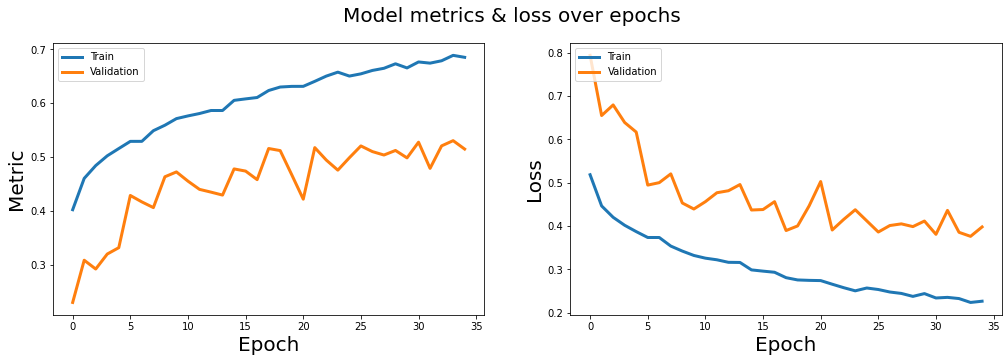

In [ ]:
plot_history(history, 
             metrics=["iou_score", "val_iou_score"], 
             losses=["loss","val_loss"])

In [ ]:
scores = model.evaluate(test_gen, steps=len(test_gen)*batch_size, verbose=0)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.40149
mean iou_score: 0.51699
mean f1-score: 0.61926


 Dice Score : 0.285750 
 Ground Truth Mask Classes:  wholebody, feet, accessories, 
 Generated Mask Classes:  upperbody, lowerbody, wholebody, feet, accessories, 


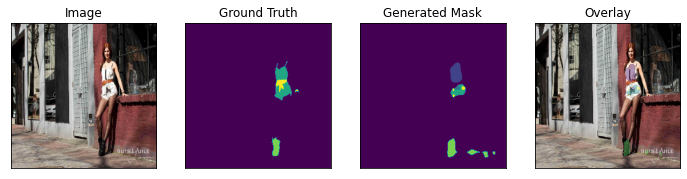

 Dice Score : 0.589583 
 Ground Truth Mask Classes:  upperbody, lowerbody, feet, accessories, 
 Generated Mask Classes:  upperbody, lowerbody, feet, 


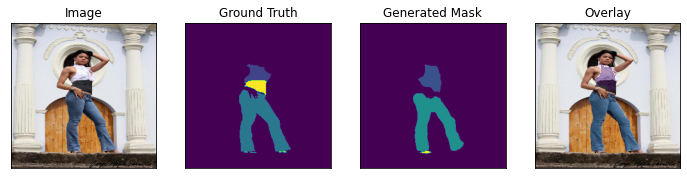

 Dice Score : 0.704164 
 Ground Truth Mask Classes:  upperbody, lowerbody, feet, accessories, 
 Generated Mask Classes:  upperbody, lowerbody, feet, 


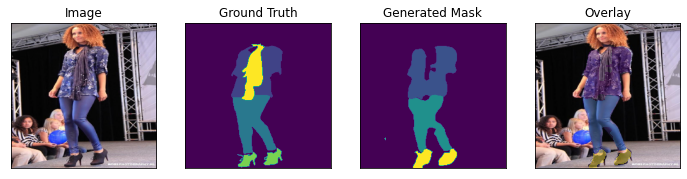

In [ ]:
num_images=3
ids = np.random.choice(np.arange(batch_size-1), size=num_images, replace=False)
x, y = next(test_gen)
for i in ids:
    image = x[i]
    ground_truth = np.argmax(np.squeeze(y[i]), axis=2)
    prediction = model.predict(np.asarray([x[i]]))
    generated_mask = np.argmax(np.squeeze(prediction), axis=2)
    overlay = np.ma.masked_where(np.squeeze(np.argmax(prediction, axis = 3)) == 0, np.squeeze(np.argmax(prediction, axis = 3)))

    print(" Dice Score : %2f " % (metrics[0](y[i], prediction)))
    cls_items = ''
    for cls in  np.unique(ground_truth):
        if cls != 0:
            cls_items += classes[cls] + ', ' 
    print(" Ground Truth Mask Classes: ", cls_items)
    cls_items = ''
    for cls in  np.unique(generated_mask):
        if cls != 0:
            cls_items += classes[cls] + ', ' 
    print(" Generated Mask Classes: ", cls_items)
    visualize(
        image=image,
        ground_truth=ground_truth,
        generated_mask=generated_mask,
        overlay=overlay,
    )



### **Visualization**



In [ ]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def apply_mask(image, mask, color, alpha=0.4):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image


def expand_mask(mini_mask, image_shape):
    """Resizes mini masks back to image size.
    """
    mask = np.zeros(image_shape[:2] + (mini_mask.shape[-1],), dtype=bool)
    for i in range(mask.shape[-1]):
        m = mini_mask[:, :, i]
        # Resize with bilinear interpolation
        m = resize(m, image_shape[:2])
        mask[:, :, i] = np.around(m).astype(np.bool)
    return mask


def display_instances(image, masks, class_names,
                      scores=None, title="",
                      figsize=(12, 12), ax=None, show_bbox=True,
                      show_mask=True, colors=None, captions=None):
    """
    masks: [height, width, num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = masks.shape[-1]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)
    
    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(1, N):
        color = colors[i]

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        contour = []
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            contour.append(verts)
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
        
        # Bounding box
        if contour:
            labels = label(padded_mask)
            props = regionprops(labels)
            bboxes = [prop.bbox for prop in props]
            for bbox in bboxes:
                y1, x1, y2, x2 = bbox
                if show_bbox:
                    p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                        alpha=0.7, linestyle="dashed",
                                        edgecolor=color, facecolor='none')
                    ax.add_patch(p)
                
            # Label
            if not captions:
                score = scores[i] if scores is not None else None
                text_label = class_names[i]
                caption = "{} {:.3f}".format(text_label, score) if score else text_label
            else:
                caption = captions[i]
            ax.text(x1, y1 + 8, caption,
                    color='w', size=11, backgroundcolor="none")
                
    ax.imshow(masked_image.astype(np.uint8))
    if auto_show:
        plt.show()

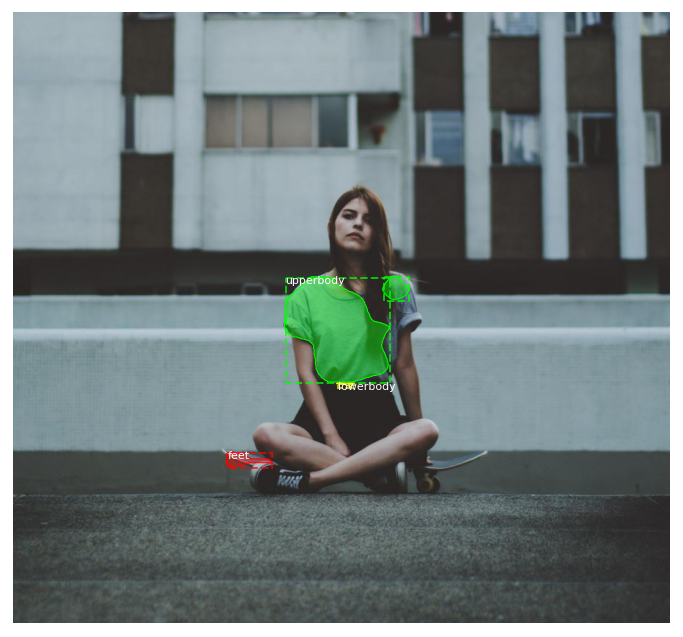

In [ ]:
img = load_img('/content/datas/test/images/07609b8383b7479d789ee3cef8fd5fa4.jpg')
img = img_to_array(img, dtype='float32')
in_img = resize(img, (IMG_HEIGHT, IMG_WIDTH))
in_img = preprocessing(in_img)
prediction = model.predict(np.asarray([in_img]))
prediction = np.squeeze(prediction)
masks = expand_mask(prediction, img.shape)
display_instances(img, masks, classes)